# 1. Requerimientos

In [ ]:
!pip install einops
!pip install transformers
!pip install tiktoken
!pip install openai
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 975.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


# 2. Librerias

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, RobertaTokenizerFast
import os
from torch.utils.data.dataset import Dataset
from transformers.tokenization_utils import PreTrainedTokenizer
from filelock import FileLock
from transformers.utils import logging
from typing import Dict, List, Optional
import pickle
import random
import time
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import numpy as np
from einops import rearrange
import math
import random
import tiktoken
import copy
import time
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import Trainer, TrainingArguments, GPT2Config, GPT2LMHeadModel,GPT2Model, GPT2Tokenizer,get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import RandomSampler

#3. Arquitecturas

Funciones de clase de la red LSTM y capa de atención. Más funciones auxiliares para calcular la pérdida entre estrofas poéticas.
El modelo GPT2 se importa en la sección 7. Modelos

## Red Recurrente + Atención

In [ ]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
    # Inicialización de la capa con la función softmax para normalizar los pesos de atención
        self.softmax = nn.Softmax(dim=-1)

    # Método forward que realiza la operación de atención
    def forward(self, q, k, v, mask=None, e=1e-12):
        # Obtiene las dimensiones del lote, número de cabezas, longitud de la secuencia y dimensión del tensor clave
        batch_size, head, length, d_tensor = k.size()

        # Producto tensorial entre queries y keys usando la notación de Einstein
        score = torch.einsum("bhid,bhjd->bhij", q, k)

        # Escalamiento de valores de atención
        score = score / math.sqrt(d_tensor)

        # Máscara opcional
        if mask is not None:
            score = score.masked_fill(mask == 0, -e)

        # Softmax pesos normalizados de atención
        score = self.softmax(score)

        # Score por pesos de atención
        v = score @ v

        # Salida ponderada y pesos de atención
        return v, score

In [ ]:
# Capa de atención con múltiples cabezas
class MultiHeadAttentionLSTM(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttentionLSTM, self).__init__()

        # Número de cabezas de atención
        self.n_head = n_head

        # Capa de atención con producto punto escalado
        self.attention = ScaleDotProductAttention()

        # Capas lineales para transformar entradas en (q,k,v) para cada cabeza de atención
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # Capa lineal salidas
        self.w_concat = nn.Linear(d_model, d_model)

    # Método forward atención múltiples cabezas
    def forward(self, x, mask=None):
        q, k, v = self.w_q(x), self.w_k(x), self.w_v(x)
        # Reorganización de dimensiones
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.n_head), (q, k, v))

        out, attention = self.attention(q, k, v, mask=mask)

        # Reorganización de salida y aplicación capa lineal de concatenación y proyección
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.w_concat(out)

        return out


In [ ]:
#Red Self-attention con LSTM
class SelfAttentionLstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_head):
        super(SelfAttentionLstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Capa de atención con múltiples cabezas
        self.multi_attention = MultiHeadAttentionLSTM(d_model=input_size, n_head=n_head)

        # Capa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        x = self.multi_attention(x)

        # Inicializar estados ocultos y de celda para la capa LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda")
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to('cuda')

        # Capa LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        return out


### Funcion de obtención de índices de inicio y termino de estrofas

**Función que se ha reformulado desde el paper original**

In [ ]:
def get_idx_two_line(token, newline_token_id):
    '''
    Función que recibe los tokens del modelo GPT2.
    Luego busca donde existe un doble salto de línea, que marca el fin de una estrofa y el inicio de la siguiente
    El output es una lista del estilo ejemplo: [[0, 5], [10, 40], [70, block_size]] donde cada par de índices es el inicio y fin de una estrofa del input de tamaño block_size
    '''
    token = token[0].tolist()
    index_token = [0]
    consecutive_count = 0
    for i in range(len(token)):
        # Verificar si el token actual es un token de salto de línea
        if token[i] == newline_token_id:
            # Si es el inicio de tokens consecutivos, guardar el índice
            if consecutive_count == 0:
                consecutive_start_index = i
            # Incrementar el conteo de tokens consecutivos
            consecutive_count += 1
        else:
            # Si se encuentran tokens consecutivos de salto de línea
            if consecutive_count >= 2:
                # Guardar los índices de inicio y fin de tokens consecutivos de salto de línea
                index_token.append(consecutive_start_index)
                index_token.append(i)
            # Reiniciar el conteo consecutivo y el índice de inicio
            consecutive_count = 0
            consecutive_start_index = None
    # si hay paddings, el término real del fin de la última estrofa es el token <EOS>.
    if token[-1] == padding_token_id:
        index_token.append(token.index(padding_token_id))
    # si no hay padding, se ha truncado, el token del fin de la última estrofa es el último token del input
    else:
        index_token.append(len(token))
    # Crear pares de índices donde comienza y termina una estrofa de X número de líneas
    index_khotho = [index_token[i:i+2] for i in range(0, len(index_token), 2)]
    index_khotho = [i for i in index_khotho if len(i) == 2]
    index_khotho = [index_khotho]

    return index_khotho

### Función de perdida de la LSTM

In [ ]:
def loss_kho_tho(tokens, embedding, modelo_lstm, newline_token_id):

    '''
    Función que calcula la pérdida de la LSTM entre 2 vectores contextuales, cada uno de estrofas consecutivas.
    Esta función llama a la función anterior que entrega los indices donde comienzan y terminan las estrofas.
    De esta forma extrae los embeddings de cada estrofa, los hace pasar por la LSTM y extrae el vector contextual.
    Se procede a comparar los vectores contextuales de estrofas consecutivas. Ej: E1 vs E2, y E2 vs E3.
    Si solo hay 1 estrofa no se calcula la loss.
    De esta forma por cada input, se calcula la loss media entre pares de estrofas existentes.
    '''

    tokens = torch.unsqueeze(tokens,0)
    pair_list = get_idx_two_line(tokens, newline_token_id)[0]
    embedding = torch.unsqueeze(embedding,0)

    total_lost = 0
    loss = nn.MSELoss().to(device)

    #se calcula la loss para estrofas consecutivas
    for i in range(len(pair_list) - 1):
      #Extract indices de los segmentos
      one_start, one_end = pair_list[i][0], pair_list[i][1]
      two_start, two_end = pair_list[i + 1][0], pair_list[i + 1][1]
      #Extraer embeddings usando los indices
      embedd_one = modelo_lstm(embedding[:, one_start: one_end + 1, :])
      embedd_two = modelo_lstm(embedding[:, two_start: two_end + 1, :])

      total_lost += loss(embedd_one,embedd_two)

    return total_lost

En nuestro caso los inputs por construcción solo presentan 2 estrofas. Sin embargo las funciones anteriores se han adaptado para tratar con grupos de N estrofas consecutivas. De esta forma se debiese poder controlar la deriva temática a lo largo de N estrofas. Sin embargo la ventana contextual crecerá y la limitante será la memoria para entrenar.

# 4. Data de Entrenamiento y Validación


---

Se proporcionan tres opciones de archivos de texto: "poemas_mistral.txt", "poemas_neruda.txt" y "poemas_total.txt". Se utiliza el último por defecto, pero se pueden cambiar los nombres de archivo para procesar diferentes conjuntos de poemas y generar poemas más similares al estilo de cada autor.

---

In [ ]:
#archivo_texto = "poemas_mistral.txt"
#archivo_texto = "poemas_neruda.txt"
archivo_texto = "poemas_total.txt"

with open(archivo_texto, 'r') as archivo:
    contenido = archivo.read()

# Separa los poemas por '\n\n\n'
poemas = contenido.split('\n\n\n')

# Cuenta cuántos poemas hay
cantidad_poemas = len(poemas)

print(f'El archivo tiene {cantidad_poemas} poemas.')

# Inicializa la variable para contar estrofas
cantidad_estrofas = 0

# Recorre cada poema y cuenta las estrofas en cada uno
for poema in poemas:
    estrofas = poema.split('\n\n')
    cantidad_estrofas += len(estrofas)

print(f'El archivo tiene {cantidad_estrofas} estrofas.')

El archivo tiene 482 poemas.
El archivo tiene 3602 estrofas.


In [ ]:
# Leer el contenido del archivo
with open(archivo_texto, "r", encoding="utf-8") as file:
    texto = file.read()

print(f"Tamaño del corpus: {len(texto):,} caracteres \n\n")

# Separar en poemas individuales
poemas = texto.split("\n\n\n")

# Eliminar espacios en blanco o poemas nulos, y convertir a minúsculas
poemas = [poema for poema in poemas if len(poema) > 0]
poemas = [poema.strip() for poema in poemas]
poemas = [poema.lower() for poema in poemas]

#dividir en estrofas por poema
estrofas_por_poema = [poema.split("\n\n") for poema in poemas]

#unir 2 estrofas consecutivas, dentro de cada poema.
pares_de_estrofas = []
for estrofa in estrofas_por_poema:
    for i in range(0,len(estrofa)-1):
        pares_de_estrofas.append(estrofa[i]+"\n\n"+estrofa[i+1])


#renombrar a poemas por facilidad
poemas = pares_de_estrofas

#desordenar los grupos de estrofas
random.shuffle(poemas)

# Separar en train y validacion en proporción 90-10%
train_poemas = poemas[:int(len(poemas)*0.9)]
valid_poemas = poemas[int(len(poemas)*0.9):]

# Guardar en archivos
with open("poemas.txt", "w", encoding="utf-8") as file:
    file.write("\n\n".join(poemas))

with open("train_poemas.txt", "w", encoding="utf-8") as file:
    file.write("\n\n".join(train_poemas))

with open("valid_poemas.txt", "w", encoding="utf-8") as file:
    file.write("\n\n".join(valid_poemas))

print(f"Ejemplo de Grupo de Estrofa que se le ingresará al modelo: \n\n {poemas[0]}")

Tamaño del corpus: 664,551 caracteres 


Ejemplo de Grupo de Estrofa que se le ingresará al modelo: 

 ruth lo miró de la planta a la frente,
y fue sus ojos saciados bajando,
como el que bebe en inmensa corriente...

al regresar a la aldea, los mozos
que ella encontró la miraron temblando.
pero, en su sueño booz fue su esposo...


Ver qué palabras son comunes en el dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


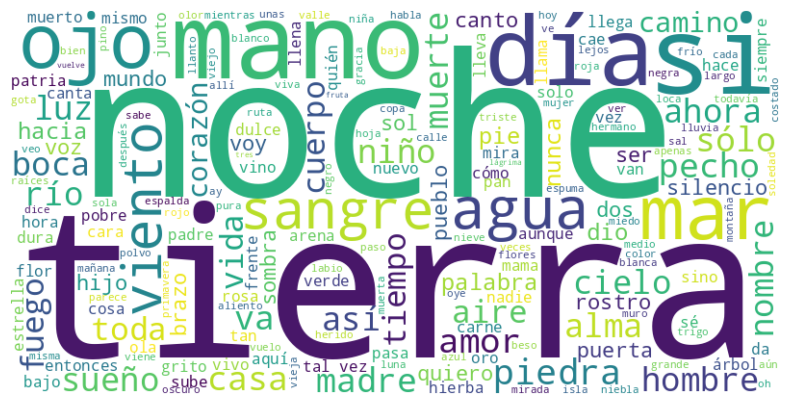

In [ ]:
import nltk
from nltk.corpus import stopwords

# Descarga la lista de stopwords en español
nltk.download('stopwords')
stopwords_espanol = set(stopwords.words('spanish'))

# Especifica la ruta del archivo que deseas leer
archivo_path = 'poemas.txt'  # Reemplaza 'ruta_del_archivo.txt' con la ruta correcta

# Lee el contenido del archivo
with open(archivo_path, 'r', encoding='utf-8') as file:
    contenido = file.read()

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords = stopwords_espanol).generate(contenido)

# Muestra la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 5. Tokenizadores y Creación de Datasets

---
**Sólo ejecutar 1 de los tokenizadores**

Para los resultados del proyecto se ejecutaron:
1.     5.1 en conjunción con el modelo 7.A.
2.     5.2 en conjunción con el modelo 7.B.

Aunque las otras combinaciones debiesen ser factibles de ser ejecutadas.


---

## 5.1. Tokenizador SubPalabra: Tiktoken

In [ ]:
import tiktoken

# Cargar la codificación "gpt2" de tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

# Obtener los tokens del texto
tokens = tokenizer.encode(poemas[0])

# Decodificar los tokens a bytes
tokens_bytes = [tokenizer.decode_single_token_bytes(token) for token in tokens]

# Convertir los bytes a cadenas de texto
tokens_texto = [bytes.decode("utf-8", errors="replace") for bytes in tokens_bytes]

# Tamaño del vocabulario

vocab_size = tokenizer.n_vocab

# Imprimir el número de tokens y los tokens en bytes y texto
print("Poema:\n\n", poemas[0])
print("Número de tokens:", len(tokens))
print("Tokens:", tokens)
print("Tokens en bytes:", tokens_bytes)
print("Tokens en texto:", tokens_texto)
print("Tamaño del vocabulario:", vocab_size)

# añadirle caracteres especiales
tokenizer = tiktoken.Encoding(
    name="tiktoken",
    pat_str=tokenizer._pat_str,
    mergeable_ranks=tokenizer._mergeable_ranks,
    special_tokens={
        **tokenizer._special_tokens,
        '<BOS>': vocab_size,
        '<EOS>': vocab_size + 1,
        '<PAD>': vocab_size + 2
    }
)

# identificar el id del token newline
newline_token_id = tokenizer.encode('\n')[0]
# identificar el id del padding
padding_token_id = tokenizer.encode("<PAD>", allowed_special="all")[0]
# identificar el id del EOS
eos_token_id =  tokenizer.encode("<EOS>", allowed_special="all")[0]
# nuevo tamaño de vocabulario
vocab_size = tokenizer.n_vocab
print("Tamaño del vocabulario actualizado:", vocab_size)
print("Id de la nueva linea:", newline_token_id)
print("Caracteres especiales:", tokenizer._special_tokens)

Poema: ruth lo miró de la planta a la frente,
y fue sus ojos saciados bajando,
como el que bebe en inmensa corriente...

al regresar a la aldea, los mozos
que ella encontró la miraron temblando.
pero, en su sueño booz fue su esposo...
Número de tokens: 90
Tokens: [81, 1071, 2376, 5720, 10205, 390, 8591, 4618, 64, 257, 8591, 277, 1156, 68, 11, 198, 88, 37911, 2341, 267, 73, 418, 5360, 72, 22484, 275, 1228, 25440, 11, 198, 785, 78, 1288, 8358, 307, 1350, 551, 287, 45535, 64, 1162, 8289, 68, 986, 198, 198, 282, 842, 411, 283, 257, 8591, 257, 335, 18213, 11, 22346, 6941, 37925, 198, 4188, 304, 8466, 2207, 756, 81, 10205, 8591, 5720, 8045, 2169, 65, 11993, 13, 198, 525, 78, 11, 551, 424, 20889, 31329, 1489, 8590, 37911, 424, 1658, 1930, 78, 986]
Tokens en bytes: [b'r', b'uth', b' lo', b' mir', b'\xc3\xb3', b' de', b' la', b' plant', b'a', b' a', b' la', b' f', b'rent', b'e', b',', b'\n', b'y', b' fue', b' sus', b' o', b'j', b'os', b' sac', b'i', b'ados', b' b', b'aj', b'ando', b',', b'\n', 

Se definirá el bloque contextual como cada grupo de estrofas, por lo tanto se requiere saber cuál es la cantidad máxima de tokens codificados en cada grupo. Luego se definirá el bloque contextual. Se truncarán los grupos de estrofan que sobrepasen el tamaño del bloque contextual.

La estrofa más larga tiene 1207 tokens


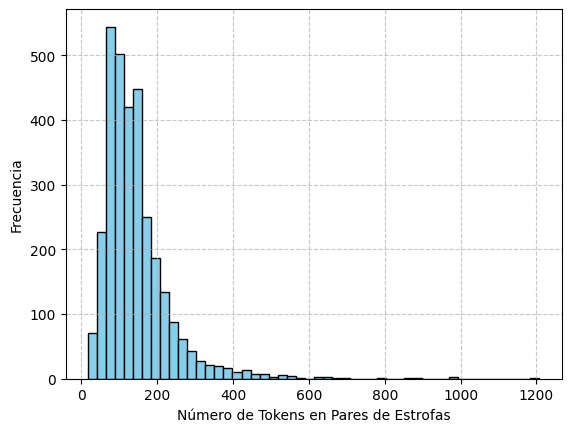

Número de inputs al modelo: 3120


In [ ]:
# codificar cada estrofa de cada poema
poemas_estrofas_codificado = [tokenizer.encode(estrofa) for estrofa in poemas]

# obtener el largo de cada estrofa de cada poema
poemas_estrofas_largo = [len(estrofa) for estrofa in poemas_estrofas_codificado]

# obtener el largo maximo global de una estrofa
block_size_estrofa = max(poemas_estrofas_largo)

print(f"La estrofa más larga tiene {block_size_estrofa} tokens")

import matplotlib.pyplot as plt
plt.hist(poemas_estrofas_largo, bins=50, color='skyblue', edgecolor='black')

# Agregando etiquetas y título en español
plt.xlabel('Número de Tokens en Pares de Estrofas')
plt.ylabel('Frecuencia')
#plt.title('Distribución de Longitudes de Pa Estrofas de Poemas')

# Agregando una cuadrícula para una mejor legibilidad
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

print(f"Número de inputs al modelo: {len(poemas_estrofas_codificado)}")

La mayoría de estrofas tienen menos de 150 tokens. Un bloque contextual de 250 tokens parece apropiado para limitar el uso de memoria.

In [ ]:
## Ventana contextual
MAX_LEN = 250

Se crea una clase que añade a cada grupo de estrofas el carácter de inicio y de fin de texto. Además se trunca si sobrepasa la ventana y se agrega padding en caso de que no.
Por último devuelve la mascara de atención en donde se encuentran los tokens de padding, para no calcular la loss en dichos tokens

In [ ]:
class PoemDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        for i in data:
            # Codificar el texto con tokens '<BOS>' (inicio del poema) y '<EOS>' (fin del poema)
            token_counts = self.codificar('<BOS>' + i + '<EOS>', max_length)
            self.input_ids.append(token_counts['input_ids'])
            self.attn_masks.append(token_counts['attention_mask'])

    def codificar(self, text, max_length):
        """
        Tokenizar el texto de entrada y devolver el recuento de tokens.
        Parámetros:
            text (str): El texto de entrada que se tokenizará.
            max_length (int): Longitud máxima para el relleno.
        Devoluciones:
            dict: Un diccionario que contiene el recuento de tokens.
        """
        tokens = self.tokenizer.encode(text, allowed_special="all")
        truncated_tokens = tokens[:max_length]  # Truncar hasta max_length
        padding_length = max_length - len(truncated_tokens)
        # Agregar tokens de relleno
        padded_index = self.tokenizer.encode("<PAD>", allowed_special="all")
        end_index = self.tokenizer.encode("<EOS>", allowed_special="all")
        padded_tokens = torch.tensor(truncated_tokens + padded_index * padding_length)
        # Enmascarar los tokens de relleno y el token EOS
        attention_mask = torch.tensor((padded_tokens != padded_index[0]) & ((padded_tokens != end_index[0])))
        return {
            'input_ids': padded_tokens,
            'attention_mask': attention_mask
        }

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
import warnings

# Disable all warnings
warnings.simplefilter("ignore")
dataset_train = PoemDataset(train_poemas, tokenizer, MAX_LEN)
dataset_valid = PoemDataset(valid_poemas, tokenizer, MAX_LEN)

In [ ]:
## EJEMPLO DE UN INPUT CODIFICADO Y SU MASCARA
dataset_train[0]

(tensor([50257,    81,  1071,  2376,  5720, 10205,   390,  8591,  4618,    64,
           257,  8591,   277,  1156,    68,    11,   198,    88, 37911,  2341,
           267,    73,   418,  5360,    72, 22484,   275,  1228, 25440,    11,
           198,   785,    78,  1288,  8358,   307,  1350,   551,   287, 45535,
            64,  1162,  8289,    68,   986,   198,   198,   282,   842,   411,
           283,   257,  8591,   257,   335, 18213,    11, 22346,  6941, 37925,
           198,  4188,   304,  8466,  2207,   756,    81, 10205,  8591,  5720,
          8045,  2169,    65, 11993,    13,   198,   525,    78,    11,   551,
           424, 20889, 31329,  1489,  8590, 37911,   424,  1658,  1930,    78,
           986, 50258, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
         50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
         50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
         50259, 50259, 50259, 50259, 50259, 50259, 5

In [ ]:
# EL MISMO INPUT DECODIFICADO
print(tokenizer.decode(dataset_train[0][0].tolist()))

<BOS>ruth lo miró de la planta a la frente,
y fue sus ojos saciados bajando,
como el que bebe en inmensa corriente...

al regresar a la aldea, los mozos
que ella encontró la miraron temblando.
pero, en su sueño booz fue su esposo...<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PA

In [ ]:
#contar numero de tokens unicos (vocabulario efectivo)

tokens_unicos = [token for poema in poemas_estrofas_codificado for token in poema]

print(f"Cantidad de tokens únicos en el set de entrenamiento es: {len(set(tokens_unicos))}")

Cantidad de tokens únicos en el set de entrenamiento es: 3772


## 5.2. Tokenizador preentrenado: GPT2-Español

In [ ]:
## Ventana contextual
MAX_LEN = 200

Se trabajara con el tokenizador del [modelo](https://colab.research.google.com/drive/1HVt5SJ22sXwhuqZX_DKoxZ5nJF4BFGTH?authuser=5#scrollTo=1QrQvNhrBH0j&line=1&uniqifier=1) GPT2 pequeño entrenado con el corpus de wikipedia en español + libros de literatura y poesía.

In [ ]:
model_name = "DeepESP/gpt2-spanish"

In [ ]:
#importar tokenizador
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

#agregar los caracteres especiales
special_tokens_dict = {
    'bos_token': '<BOS>',
    'eos_token': '<EOS>',
    'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

#definir el ID de separacion de espacio, y obtener el tamaño del vocabulario
newline_token_id = tokenizer.encode('\n')[0]
padding_token_id = tokenizer.encode('<PAD>')[0]
eos_token_id = tokenizer.encode('<EOS>')[0]
vocab_size = len(tokenizer)

**Creación del dataset**

In [ ]:
class PoemDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, gpt2_type='gpt2'):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for i in data:
            encodings_dict = tokenizer('<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length')

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

La estrofa más larga tiene 791 tokens 



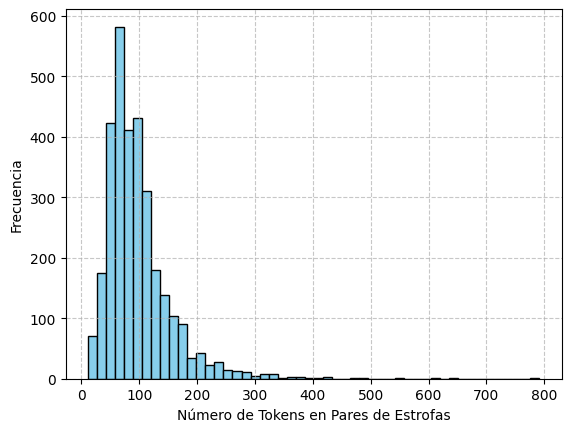

Número de inputs al modelo: 3120


In [ ]:
# codificar cada estrofa de cada poema
poemas_estrofas_codificado = [tokenizer.encode(estrofa) for estrofa in poemas]

# obtener el largo de cada estrofa de cada poema
poemas_estrofas_largo = [len(estrofa) for estrofa in poemas_estrofas_codificado]

# obtener el largo maximo global de una estrofa
block_size_estrofa = max(poemas_estrofas_largo)

print(f"La estrofa más larga tiene {block_size_estrofa} tokens \n")

import matplotlib.pyplot as plt
plt.hist(poemas_estrofas_largo, bins=50, color='skyblue', edgecolor='black')

# Agregando etiquetas y título en español
plt.xlabel('Número de Tokens en Pares de Estrofas')
plt.ylabel('Frecuencia')
#plt.title('Distribución de Longitudes de Pa Estrofas de Poemas')

# Agregando una cuadrícula para una mejor legibilidad
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

print(f"Número de inputs al modelo: {len(poemas_estrofas_codificado)}")

In [ ]:
#Ejemplo de tokenizacion
tokens_recuperados = tokenizer.convert_ids_to_tokens(poemas_estrofas_codificado[0])
tokens = [tokenizer.convert_tokens_to_string(tokens) for tokens in tokens_recuperados]
print("Tokens Recuperados:", tokens)

Tokens Recuperados: ['ru', 'th', ' lo', ' miró', ' de', ' la', ' planta', ' a', ' la', ' frente', ',', '\n', 'y', ' fue', ' sus', ' ojos', ' sa', 'ciados', ' bajando', ',', '\n', 'como', ' el', ' que', ' bebe', ' en', ' inmensa', ' corriente', '...', '\n', '\n', 'al', ' regresar', ' a', ' la', ' aldea', ',', ' los', ' mozos', '\n', 'que', ' ella', ' encontró', ' la', ' miraron', ' temblando', '.', '\n', 'pero', ',', ' en', ' su', ' sueño', ' bo', 'oz', ' fue', ' su', ' esposo', '...']


**Datasets**

In [ ]:
dataset_train = PoemDataset(train_poemas, tokenizer, MAX_LEN)
dataset_valid = PoemDataset(valid_poemas, tokenizer, MAX_LEN)

In [ ]:
#contar numero de tokens unicos (vocabulario efectivo)

tokens_unicos = [token for poema in poemas_estrofas_codificado for token in poema]

print(f"Cantidad de tokens únicos en el set de entrenamiento es: {len(set(tokens_unicos))}")

Cantidad de tokens únicos en el set de entrenamiento es: 11965


Existen más tokens únicos con el tokenizador pre-entrenado puesto que este tiende a conservar palabras enteras, por lo que suma al vocabulario efectivo. Tiktoken por otra parte es más granular, subdivide las palabras por lo cual sus tokens únicos son aprox. 3000.

# 6. Funciones de entrenamiento SPT-GPT2

**Obs: Ejecutar primero la sección de tokenizador que se quiera utilizar para construir el dataset, antes de entrenar.**

In [ ]:
# logging time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# para plotear losses
def plot_losses(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')

    plt.title('Training and Validation Losses per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def train(model, model_lstm, iterator, optimizer, criterion, scheduler, newline_token_id, device, sp_gpt2 = True):

  epoch_loss = 0
  epoch_loss_lstm = 0
  loss_lstm = 0
  model.train()

  for step, batch in enumerate(iterator):

    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    #mascara de los paddings
    b_masks = batch[1].to(device)

    #setear los labels de los paddings en -100 para que no se calcule su loss
    b_labels[b_input_ids == padding_token_id] = -100

    optimizer.zero_grad()

    # si bien se entrega la mascara de padding, esto no debiese importar puesto que GPT2 es autoregresivo y los paddings están al final. i.e no se presta atención por defecto.
    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks,
                    token_type_ids=None)

    loss_gpt = outputs[0]
    logits = outputs.logits
    #extraer los embeddings de alto nivel a la salida del modelo gpt
    embedding = model.transformer(b_input_ids,
                                 attention_mask=b_masks,
                                 token_type_ids=None)[0]
    # sumar la loss de la LSTM
    if sp_gpt2:
      # se recorre cada elemento del batch y se calcula su loss lstm
      loss_lstm = sum([loss_kho_tho(b_input_ids[i],embedding[i], model_lstm, newline_token_id) for i in range(b_input_ids.shape[0])])*5
    loss_total = loss_gpt + loss_lstm
    batch_loss = loss_total.item()
    epoch_loss += batch_loss
    epoch_loss_lstm += loss_lstm

    loss_total.backward()
    optimizer.step()
    scheduler.step()

  return epoch_loss / len(iterator), epoch_loss_lstm/len(iterator)

def evaluate(model, model_lstm, iterator, criterion, newline_token_id, device, sp_gpt2=True):

  epoch_loss = 0
  epoch_loss_lstm = 0
  loss_lstm = 0
  model.eval()

  with torch.no_grad():

    for step, batch in enumerate(iterator):

      b_input_ids = batch[0].to(device)
      b_labels = batch[0].to(device)
      b_masks = batch[1].to(device)

      b_labels[b_input_ids == padding_token_id] = -100

      outputs = model(b_input_ids,
                                  labels=b_labels,
                                  attention_mask=b_masks,
                                  token_type_ids=None)

      loss_gpt = outputs[0]
      logits = outputs.logits
      embedding = model.transformer(b_input_ids,
                                   attention_mask=b_masks,
                                   token_type_ids=None)[0]
      if sp_gpt2:
        loss_lstm = sum([loss_kho_tho(b_input_ids[i],embedding[i], model_lstm, newline_token_id) for i in range(b_input_ids.shape[0])])*5
      loss_total = loss_gpt + loss_lstm

      batch_loss = loss_total.item()
      epoch_loss += batch_loss
      epoch_loss_lstm += loss_lstm

  return epoch_loss / len(iterator), epoch_loss_lstm/len(iterator)

In [ ]:
def entrenar_red(model, model_lstm, tokenizer, train_loader, valid_loader, newline_token_id, device, criterion, optimizer, scheduler, num_epochs, tipo_tokenizer = None, sp_gpt2 = True):
  best_valid_loss = float('inf')

  train_losses = []
  valid_losses = []

  train_losses_lstm = []
  valid_losses_lstm = []

  model = model.to(device)
  model_lstm = model_lstm.to(device)
  criterion = criterion.to(device)

  for epoch in range(num_epochs):

    start_time = time.time()
    #entrenamiento y validación
    train_loss, train_lstm_loss = train(model, model_lstm, train_loader, optimizer, criterion, scheduler, newline_token_id, device, sp_gpt2)
    valid_loss, valid_lstm_loss = evaluate(model, model_lstm, valid_loader, criterion, newline_token_id, device, sp_gpt2)


    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_losses_lstm.append(train_lstm_loss)
    valid_losses_lstm.append(valid_lstm_loss)

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}, LSTM loss: {train_lstm_loss:.3f}')
        print(f'\t Test. Loss: {valid_loss:.3f}, LSTM loss: {valid_lstm_loss:.3f}')

    #cada 5 epocas generar poemas
    if (epoch + 1) % 5 == 0:
        sample_outputs = model.generate(
                                  generated,
                                  do_sample=True,
                                  top_k=10,
                                  max_length=MAX_LEN,
                                  top_p=0.95,
                                  num_return_sequences=1,
                                  suppress_tokens = [padding_token_id],
                                  renormalize_logits = True
                                  )

        for i, sample_output in enumerate(sample_outputs):
            if tipo_tokenizer == "tiktoken":
              print("\n\nPoema Generado N° {}: \n {}\n\n".format(i, tokenizer.decode(sample_output.tolist())))
            else:
              print("\n\nPoema Generado N° {}: \n {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


  return model, train_losses, valid_losses

Función para evaluar la creatividad de un poema generado

In [ ]:
def evaluate_creativity(model, tokenizer, poems, temperatura, num_context_inputs=200, usar_temperatura=True):
    # Seleccionar aleatoriamente num_context_inputs poemas
    selected_poems = random.sample(poems, num_context_inputs)
    # Extraer la primera oración de cada poema seleccionado como entradas de contexto
    context_inputs = [poem.split('\n')[0].strip() for poem in selected_poems]
    context_inputs_encoded = []
    for input in context_inputs:
        if tipo_tokenizer == "tiktoken":
            context_inputs_encoded.append(torch.tensor(tokenizer.encode(input, allowed_special="all")).unsqueeze(0))
        if tipo_tokenizer == "preentrenado":
            context_inputs_encoded.append(torch.tensor(tokenizer.encode(input)).unsqueeze(0))
    # Versos del conjunto de entrenamiento
    versos = []
    for poema in poems:
        versos += poema.split("\n")
    # Inicializar variables para el cálculo del puntaje de creatividad
    total_creativity_score = 0
    # Generar poemas y calcular el puntaje de creatividad para cada entrada de contexto
    for i, prompt in enumerate(context_inputs_encoded):
        print(f"Contexto número: {i}")
        # Generar un poema utilizando el modelo
        prompt = prompt.to(device)
        #Escoger entre temperatura u otro parametro (top_k y top_p)
        if usar_temperatura:
            generated_poem = model.generate(
                prompt,
                do_sample=True,
                max_length=80,
                top_k=0,
                num_return_sequences=1,
                temperature=temperatura,
                renormalize_logits=True
            )[0]
        else:
            generated_poem = model.generate(
                prompt,
                do_sample=True,
                top_k=50,
                max_length=80,
                top_p=0.95,
                num_return_sequences=1,
                renormalize_logits=True
            )[0]
        if tipo_tokenizer == "tiktoken":
            generated_poem = tokenizer.decode(generated_poem.tolist())
        else:
            generated_poem = tokenizer.decode(generated_poem, skip_special_tokens=True)
        # Convertir el tensor del poema generado a una lista de IDs de versos
        verses_generated = generated_poem.split("\n")
        # Calcular ci (proporción de versos en el conjunto de entrenamiento respecto al total de versos en el poema generado)
        ci = sum(verse_generated in versos for verse_generated in verses_generated) / len(verses_generated)
        # Actualizar el puntaje total de creatividad
        total_creativity_score += (1 - ci)
    # Calcular el puntaje promedio de creatividad (C)
    creativity_score = total_creativity_score / num_context_inputs
    return creativity_score

# 7.A Entrenamiento desde 0 con SP-GPT2

---
Se importa sólo la arquitectura desde HF, puesto que la función de generación ofrece mayores parámetros de control. **Recomendado Definir el Tokenizador 1.**
Se utilizara un modelo más pequeño que el estándar dado el pequeño conjunto de datos, para evitar el overfitting.
**No se importan los pesos del modelo gpt2 por defecto**

---

## Entrenamiento

In [ ]:
''' ¿Qué tokenizador usar? '''

#tipo_tokenizer = "preentrenado"
tipo_tokenizer = "tiktoken"

''' ¿SP-GPT2 o sólo GPT2? '''
sp_gpt2 = True

In [ ]:
##IMPORTAR SOLO ARQUITECTURA DEL MODELO GPT2 SIN PRE-ENTRENAMIENTO (ANALOGO AL PAPER)
N_EMBD = 384
configuration = GPT2Config(vocab_size=vocab_size, n_layer=6, n_head=6, n_embd=N_EMBD, n_inner=MAX_LEN)
modelo_gpt_sinpr = GPT2LMHeadModel(configuration)
modelo_gpt_sinpr.resize_token_embeddings(vocab_size)

#MODELO LSTM DISMINUYENDO A LA MITAD LOS PARAMETROS DEL PAPER
head_gpt = SelfAttentionLstm(input_size=N_EMBD,hidden_size=256, num_layers=1,n_head=2)
for param in head_gpt.parameters():
    param.require_grad = True

In [ ]:
batch_size = 8

train_dataloader = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
valid_dataloader = DataLoader(dataset_valid,
                              sampler=RandomSampler(dataset_valid),
                              batch_size=batch_size)

In [ ]:
# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50
device = torch.device('cuda')
epocas=20
optimizer = torch.optim.AdamW(modelo_gpt_sinpr.parameters(), lr=learning_rate, eps=eps)
criterion = nn.CrossEntropyLoss().to(device)
total_steps = len(train_dataloader) * epocas
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

In [ ]:
# create text generation seed prompt
prompt = "<BOS>"

if tipo_tokenizer == "tiktoken":
  generated = torch.tensor(tokenizer.encode(prompt, allowed_special="all")).unsqueeze(0)

if tipo_tokenizer == "preentrenado":
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

generated = generated.to(device)

In [ ]:
# SI QUEREMOS ENTRENAR SOLO GPT2 ENTONCES SET sp_gpt2 EN FALSE

modelo_gpt_sinpr, train_loss_A, valid_loss_A = entrenar_red(modelo_gpt_sinpr,
                                                            head_gpt,
                                                            tokenizer,
                                                            train_dataloader,
                                                            valid_dataloader,
                                                            newline_token_id,
                                                            device,
                                                            criterion,
                                                            optimizer,
                                                            scheduler,
                                                            epocas,
                                                            tipo_tokenizer = tipo_tokenizer,
                                                            sp_gpt2 = sp_gpt2)

Epoch: 01 | Epoch Time: 1m 21s
	Train Loss: 6.604, LSTM loss: 0.004
	 Test. Loss: 5.129, LSTM loss: 0.004
Epoch: 02 | Epoch Time: 1m 20s
	Train Loss: 4.784, LSTM loss: 0.007
	 Test. Loss: 4.430, LSTM loss: 0.006
Epoch: 03 | Epoch Time: 1m 20s
	Train Loss: 4.321, LSTM loss: 0.008
	 Test. Loss: 4.157, LSTM loss: 0.007
Epoch: 04 | Epoch Time: 1m 20s
	Train Loss: 4.084, LSTM loss: 0.008
	 Test. Loss: 3.997, LSTM loss: 0.007


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 05 | Epoch Time: 1m 20s
	Train Loss: 3.928, LSTM loss: 0.008
	 Test. Loss: 3.892, LSTM loss: 0.007


Poema Generado N° 0: 
 <BOS>hoy que la que no se me hace años
y no es una quieron,
que no te séndola y no quiero.

y no te me donde quiere
la pobres se me viento.
no me lo tambiendo
porque no lo que no lo quempre,
y me lo eso
que no se pino a su ció en las ojada.<EOS>de el viento
y no quedad
que se me luna no es la vuelo y se habla.<EOS>de mi cosa de mujerme
la viento
y el pecho en el viento en la mí,
y se hombre
que me qué me llega

¿y me habla y que señando no no me quiero no no esa,
y la nada,<EOS>como a la tierra y no lo esta.<EOS>y me la río.<EOS>y la brazos
la tierra no sombra

el tenga que


Epoch: 06 | Epoch Time: 1m 20s
	Train Loss: 3.811, LSTM loss: 0.009
	 Test. Loss: 3.793, LSTM loss: 0.007
Epoch: 07 | Epoch Time: 1m 20s
	Train Loss: 3.713, LSTM loss: 0.009
	 Test. Loss: 3.721, LSTM loss: 0.007
Epoch: 08 | Epoch Time: 1m 20s
	Train Loss: 3.626, LSTM loss: 0.009
	 Test

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 10 | Epoch Time: 1m 20s
	Train Loss: 3.478, LSTM loss: 0.010
	 Test. Loss: 3.568, LSTM loss: 0.007


Poema Generado N° 0: 
 <BOS>todo el viento que me olvido
de la vientras que mejé la sólo
y me quiero que lo que te amo.

no me lo que se lejólo
y en que la ciego en tuvo
y a mi cuerpo de la cuerpo
que la nombre que no lo que no lo que me en tuvo,
que la tierra que la noche,
que me di, no me la noche, me qué me lo que me viví.<EOS>la pereza

y no te dor, la piedras que me lo que me quie que tú me me la cada
y en el alma y me habla.<EOS>que me quien lo mismo yo yo yo te me día,
la más que no eso,
me donde me la más la viento me la que la ciel
y en tuvo
y yo te ha vie, no no se la vida a mi noche que te dierno me vuelvo,
y la nad que me


Epoch: 11 | Epoch Time: 1m 21s
	Train Loss: 3.412, LSTM loss: 0.010
	 Test. Loss: 3.530, LSTM loss: 0.008
Epoch: 12 | Epoch Time: 1m 21s
	Train Loss: 3.352, LSTM loss: 0.010
	 Test. Loss: 3.494, LSTM loss: 0.008
Epoch: 13 | Epoch Time: 1m 21s
	Trai

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 15 | Epoch Time: 1m 20s
	Train Loss: 3.204, LSTM loss: 0.011
	 Test. Loss: 3.422, LSTM loss: 0.008


Poema Generado N° 0: 
 <BOS>yo me voy de una casa
y me me miraba;
yo me me llevan
y dejor, me la llega
de mi pecho.

me voy a mi casa
que es que me olvido
con su caso me huentro.
pero si me lo lo que es,
y me mejor si es mujer.<EOS>de nada vuelve
y me vieja y mi alma
y me lo mismo que te sombro
que me lo que es más.
no me me voy y no la nada
y me quiero si me oigo
me, si me me oí.<EOS>y si te olvido
porque no señando
no me sé me viva,
y que me quiebra y de tuyo que me vivir
y tiempre,
que tengo si es que me otra
y cuenta y me oío que no eso tiempo.<EOS>como el viento
y que me viento que la que eso un c


Epoch: 16 | Epoch Time: 1m 21s
	Train Loss: 3.162, LSTM loss: 0.011
	 Test. Loss: 3.394, LSTM loss: 0.008
Epoch: 17 | Epoch Time: 1m 21s
	Train Loss: 3.130, LSTM loss: 0.011
	 Test. Loss: 3.388, LSTM loss: 0.008
Epoch: 18 | Epoch Time: 1m 21s
	Train Loss: 3.102, LSTM loss: 0.011


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 20 | Epoch Time: 1m 20s
	Train Loss: 3.063, LSTM loss: 0.011
	 Test. Loss: 3.385, LSTM loss: 0.008


Poema Generado N° 0: 
 <BOS>la vida en las llena de la noche
de las manzas de las rutas,
dejada en el árboles y las vuelas,
el corazón, las viviento,
por las nombres, y los huesos,
hasta los dían en la noche.

piedras, la tierra nocturna
en el mar y la luna
las que las noche la tierra.<EOS>de la vida estrellas
la noche y la tierra se hace
la tierra y el tiempo.
¡no tanto que está la noche!<EOS>de la muerte,
todo el mundo espa muerte.<EOS>de la tierra, y la más.<EOS>tampoco en la tierra que la muerte.

¡y en el canto que la más que mejor del mar!<EOS>a
la luz la luna de la muerte!<EOS>la perece
la piedra que la luna, la ciendo;





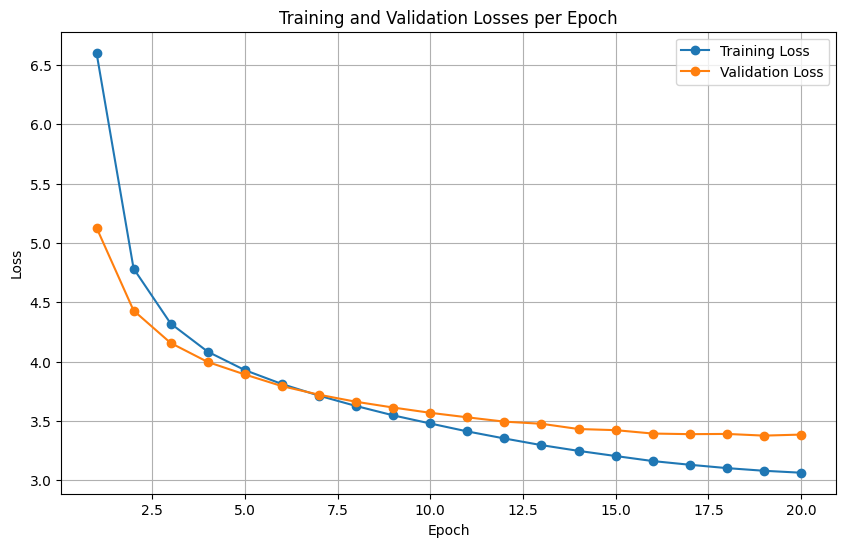

In [ ]:
plot_losses(train_loss_A, valid_loss_A)

##Generacion de Poemas: Experimentar con parámetros de Temperatura

In [ ]:
##Experimentar con diferentes prompt
prompt = "<BOS>" #libre

if tipo_tokenizer == "tiktoken":
  generated = torch.tensor(tokenizer.encode(prompt, allowed_special="all")).unsqueeze(0)

if tipo_tokenizer == "preentrenado":
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

generated = generated.to(device)

2 estilos de sampling: con temperatura o con Top-k y Top-p

In [ ]:
modelo_gpt_sinpr.eval()

TEMPERATURA = 0.6

# sample_outputs = modelo_gpt_sinpr.generate(
#                                 generated,
#                                 do_sample=True,
#                                 top_k=0,
#                                 max_length=150,
#                                 top_p=0.95,
#                                 num_return_sequences=100,
#                                 no_repeat_ngram_size=2,
#                                 suppress_tokens = [padding_token_id, eos_token_id],
#                                 renormalize_logits = True
#                                 )

sample_outputs = modelo_gpt_sinpr.generate(
                                generated,
                                do_sample=True,
                                max_length=80,
                                top_k = 0,
                                num_return_sequences=100,
                                temperature=TEMPERATURA,
                                no_repeat_ngram_size=2,
                                suppress_tokens = [padding_token_id, eos_token_id],
                                renormalize_logits = True
                                )


for i, sample_output in enumerate(sample_outputs):
    poema_generado = tokenizer.decode(sample_output.squeeze().tolist())
    print("\n\nPoema Generado N° {} \n\n: {}\n\n".format(i, poema_generado))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Se han truncado las últimas 5000 líneas del flujo de salida.
Poema Generado N° 144 

: <BOS>y la noche se me acaba.

su sencida de alma,
y su caminó con su vino
la rostro a su huerpo. no segada
se va a la siempre
como el mar.a nada. es la me la ceja
yo no hable en su reino. lleg




Poema Generado N° 145 

: <BOS>y yo sé todo lo que es la mano
con el padre de la puerta, y la vida,
y la sabe que la antes
como el cuerpo de los míos
que se me la vea a la ruta
por el que me lleva la palabra.

la vieja




Poema Generado N° 146 

: <BOS>en la piedra, vida,
por la tierra y la gajo, la noche
la luna vie, el cierta, y el amor que va
en el nuevo y una patria.

y entre los cielos, cada. no mejor., ni cuando
se van a




Poema Generado N° 147 

: <BOS>el viento de los hombres y en el cielo
de los frutos de la saber y la noche
que la muerte con mi canta.

¡para el vio que ahora no es más
y yo quiero que está visto!
es que no me vuelvo. �




Poema Generado N° 148 

: <BOS>en la noche se me llevan


In [ ]:
## Guardar los poemas generados

generated_poems = []

for i, sample_output in enumerate(sample_outputs):
  if tipo_tokenizer == "tiktoken":
            generated_poems.append(tokenizer.decode(sample_output.tolist()))
  else:
            generated_poems.append(tokenizer.decode(sample_output, skip_special_tokens=True))

output_file_path = f'ModeloA_prompt_libre_T_{int(TEMPERATURA*100)}.txt'

with open(output_file_path, 'w', encoding='utf-8') as file:
    for poem in generated_poems:
        file.write(poem + '\n\n\n')

print(f"Generated outputs are saved to: {output_file_path}")

Generated outputs are saved to: ModeloA_prompt_libre_T_60.txt


**Word Clouds**

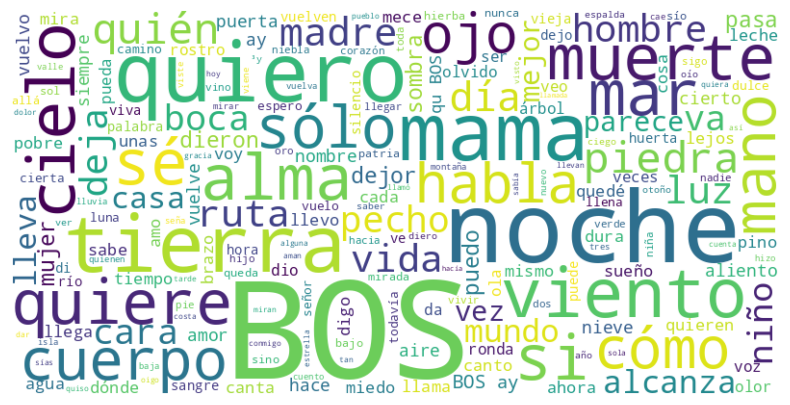

In [ ]:
archivo_path = f'ModeloA_prompt_libre_T_{int(TEMPERATURA*100)}.txt'

with open(archivo_path, 'r', encoding='utf-8') as file:
    contenido = file.read()

wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords = stopwords_espanol).generate(contenido)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#7.B. Entrenamiento SP-GPT2 con GPT2 preentrenado de Hugging Face

---

GPT2 preentrenado con el corpus de wikipedia y libros en español [link del modelo](https://huggingface.co/DeepESP/gpt2-spanish). Por lo que el entrenamiento es esencialmente realizar fine-tuning con nuestro corpus.

---

In [ ]:
''' ¿Qué tokenizador usar? '''

tipo_tokenizer = "preentrenado"
#tipo_tokenizer = "tiktoken"

''' ¿SP-GPT2 o sólo GPT2? '''
sp_gpt2 = True

## Entrenamiento

In [ ]:
#OBTENER MODELO PREENTRENADO
model_name = "DeepESP/gpt2-spanish"
configuration = GPT2Config(vocab_size=vocab_size, n_positions=MAX_LEN).from_pretrained(model_name, output_hidden_states=True)
poem_stanza_model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
poem_stanza_model.resize_token_embeddings(vocab_size)

#MODELO LSTM
head_gpt = SelfAttentionLstm(input_size=768,hidden_size=256, num_layers=1,n_head=2)
for param in head_gpt.parameters():
    param.require_grad = True

pytorch_model.bin:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [ ]:
batch_size = 8

train_dataloader = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
valid_dataloader = DataLoader(dataset_valid,
                              sampler=RandomSampler(dataset_valid),
                              batch_size=batch_size)

In [ ]:
# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50
device = torch.device('cuda')
epocas=10
optimizer = torch.optim.AdamW(poem_stanza_model.parameters(), lr=learning_rate, eps=eps)
criterion = nn.CrossEntropyLoss().to(device)
total_steps = len(train_dataloader) * epocas
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# create text generation seed prompt
prompt = "<BOS>"

if tipo_tokenizer == "tiktoken":
  generated = torch.tensor(tokenizer.encode(prompt, allowed_special="all")).unsqueeze(0)

if tipo_tokenizer == "preentrenado":
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

generated = generated.to(device)

In [ ]:
poem_stanza_model, train_loss_B, valid_loss_B  = entrenar_red(poem_stanza_model,
                                                              head_gpt,
                                                              tokenizer,
                                                              train_dataloader,
                                                              valid_dataloader,
                                                              newline_token_id,
                                                              device,
                                                              criterion,
                                                              optimizer,
                                                              scheduler,
                                                              epocas,
                                                              tipo_tokenizer = tipo_tokenizer,
                                                              sp_gpt2 = sp_gpt2)

Epoch: 01 | Epoch Time: 4m 47s
	Train Loss: 4.102, LSTM loss: 0.068
	 Test. Loss: 3.626, LSTM loss: 0.010
Epoch: 02 | Epoch Time: 4m 47s
	Train Loss: 3.193, LSTM loss: 0.019
	 Test. Loss: 3.254, LSTM loss: 0.010
Epoch: 03 | Epoch Time: 4m 47s
	Train Loss: 2.462, LSTM loss: 0.017
	 Test. Loss: 2.879, LSTM loss: 0.009
Epoch: 04 | Epoch Time: 4m 47s
	Train Loss: 1.847, LSTM loss: 0.016
	 Test. Loss: 2.585, LSTM loss: 0.010


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 05 | Epoch Time: 4m 47s
	Train Loss: 1.377, LSTM loss: 0.015
	 Test. Loss: 2.341, LSTM loss: 0.008


Poema Generado N° 0: 
 en las noches, insomne, te pareces al señor.
y al señor en su lecho de oro, en su lecho de oro.
¿en qué día de sangre que te muerde el corazón?

¡si dios quisiera volvérteme
por un instante tan sólo!
¿qué más podría darme?
¿qué más podía darme?
¿por qué tan poco tiempo
y tan poco tiempo sin verte?
¡si de mirarme tan pobre
me devolviera tu rostro!
¡si de mirarme tan pobre
me devolviera tu rostro!
¡si de mirarme tan pobre
me devolviera tu rostro!
¿por qué no me devolviera tu cara?
¿por qué no puedo
volverla a mis brazos sin verte?¡si de mirarme tan pobre
me devolviera tu rostro!
¡si de mirarme tan pobre
me devolviera tu rostro!
¡si de mirarme tan pobre
me


Epoch: 06 | Epoch Time: 4m 47s
	Train Loss: 1.049, LSTM loss: 0.015
	 Test. Loss: 2.156, LSTM loss: 0.014
Epoch: 07 | Epoch Time: 4m 47s
	Train Loss: 0.832, LSTM loss: 0.014
	 Test. Loss: 2.028, LSTM loss:

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 10 | Epoch Time: 4m 47s
	Train Loss: 0.535, LSTM loss: 0.013
	 Test. Loss: 1.886, LSTM loss: 0.010


Poema Generado N° 0: 
 -no, no chiquito, él no sabe
que las flores le dan
a la vuelta de la hoja.

-¿y qué dice eso "llanquihue"?
-que las gentes del mar
le dijeron "llanquihue"
y todo el año
le dijeron "llanquihue",
le dijeron que pusiera
su voz de cascada
sobre las gentes del mar.
yo me llamo "llanquihue",
y me dicen "llanquihue"
y "llanquihue".
-como tú no comes nunca
de esto no comprendes nada.
-porque algunas gentes del mar
le dijeron "llanquihue".
-¿y qué más? ¿es que sabéis nuestros nombres
mas que se los sabe el mar?
yo te he dicho que las calles
con tal de que te enrolla el viento,
que no te vale de nada.
-porque todos tienen ojos
y ojos




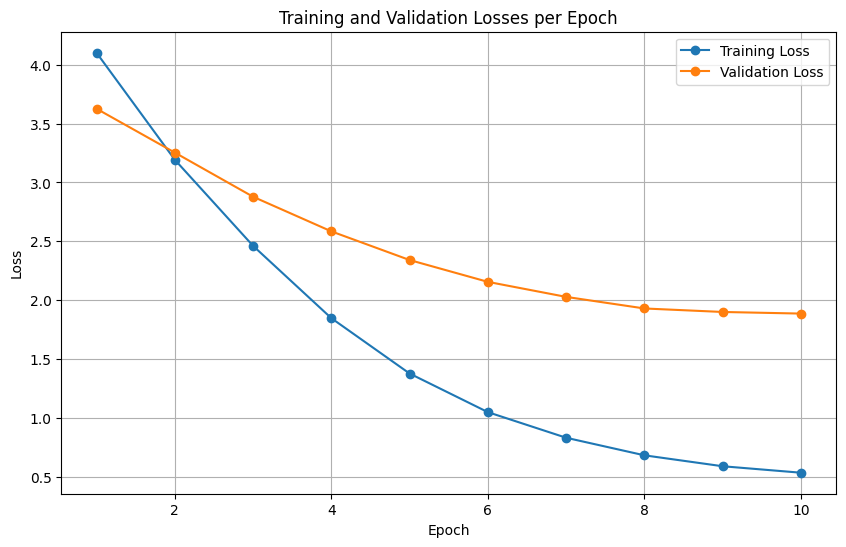

In [ ]:
plot_losses(train_loss_B, valid_loss_B)

##Generacion de Poemas: Experimentar con parámetros de Temperatura

In [ ]:
##Experimentar con diferentes prompt

prompt = "<BOS>" #libre
#prompt = "me gustas cuando callas porque estás como ausente"
#prompt = "dame la mano y danzaremos"

if tipo_tokenizer == "tiktoken":
  generated = torch.tensor(tokenizer.encode(prompt, allowed_special="all")).unsqueeze(0)

if tipo_tokenizer == "preentrenado":
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

generated = generated.to(device)

In [ ]:
poem_stanza_model.eval()

TEMPERATURA = 0.6

### OPCION 1: SAMPLING CON TOP K Y TOP P
# sample_outputs = poem_stanza_model.generate(
#                                 generated,
#                                 do_sample=True,
#                                 top_k=50,
#                                 max_length=80,
#                                 top_p=0.95,
#                                 num_return_sequences=100,
#                                 renormalize_logits = True
#                                 )

## OPCION 2: SAMPLING CON TEMPERATURA
sample_outputs = poem_stanza_model.generate(
                                generated,
                                do_sample=True,
                                max_length=80,
                                top_k = 0,
                                num_return_sequences=100,
                                temperature=TEMPERATURA,
                                renormalize_logits = True
                                )



for i, sample_output in enumerate(sample_outputs):
    if tipo_tokenizer == "tiktoken":
      print("\n\nPoema Generado N° {}: \n\n {}\n\n".format(i, tokenizer.decode(sample_output.tolist())))
    if tipo_tokenizer == "preentrenado":
      print("\n\nPoema Generado N° {}: \n\n {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




Poema Generado N° 0: 

 la noche ahora es fina,
es estricta y delgada.
la liana sube a mis sienes
o a mi garganta, colmada.
la liana sube a mis manos
y mi sangre corre por las hojas.

hierba al norte, al sur, al sur,
y la vena del aire sube
con saltos de ciervo en ira.
hier




Poema Generado N° 1: 

 pero cuando un día viene
a clavarse en mi alma
o a morderme en el corazón
como quien deja en el pecho
l'habla del mismo modo
de hijo de dios prisionero,
no puedo menos de sentirlo
como una mujer que vacila
de sí mismo y de sí mismo.

por eso voy corriendo
para salvar tu pellejo,
aunque debo




Poema Generado N° 2: 

 un día se acuerda
de este modo inolvidable:
cuando baja,
por la cuestas de
las quebradas
y subiendo siempre
a más padece,
más se crece
y se vuelve hermosa.

por estas sendas
caminan
colas y espaldas,
el nardo y el niño
y el indio que duerme.
por estas lomas
seguimos
así




Poema Generado N° 3: 

 tú te lo sabes contado.
en toda hora de la luz
tú la has visto
y la has vist

**Guardar Poemas**

In [ ]:
generated_poems = []

for i, sample_output in enumerate(sample_outputs):
  if tipo_tokenizer == "tiktoken":
            generated_poems.append(tokenizer.decode(sample_output.tolist()))
  else:
            generated_poems.append(tokenizer.decode(sample_output, skip_special_tokens=True))

output_file_path = f'ModeloB_prompt_libre_T_{int(TEMPERATURA*100)}.txt'

with open(output_file_path, 'w', encoding='utf-8') as file:
    for poem in generated_poems:
        file.write(poem + '\n\n\n')

print(f"Generated outputs are saved to: {output_file_path}")

Generated outputs are saved to: ModeloB_prompt_libre_T_10.txt


**Nube de palabras**

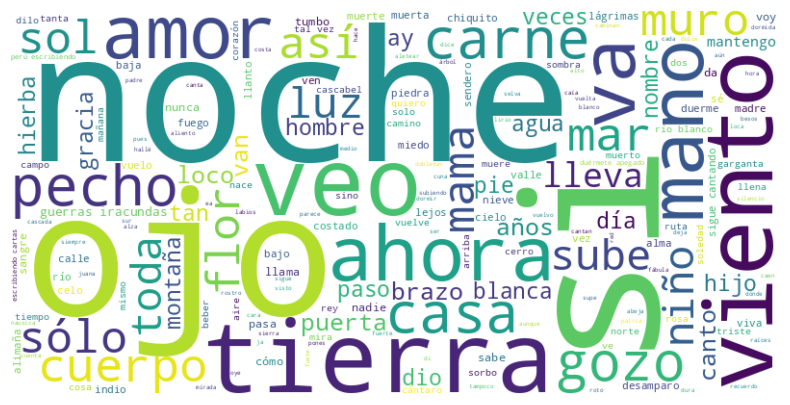

In [ ]:
archivo_path = f'ModeloB_prompt_libre_T_{int(TEMPERATURA*100)}.txt'

with open(archivo_path, 'r', encoding='utf-8') as file:
    contenido = file.read()

wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords = stopwords_espanol).generate(contenido)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Creatividad**

Tomar 100 versos aleatorios del training dataset, y evaluar la creatividad media de los 100 poemas generados para diferentes temperaturas.

In [ ]:
creatividad_altaT = evaluate_creativity(poem_stanza_model, tokenizer, poemas, temperatura = 1.0, num_context_inputs=100)
creatividad_bajaT = evaluate_creativity(poem_stanza_model, tokenizer, poemas, temperatura = 0.1, num_context_inputs=100)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 49


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 51


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 52


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 55


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 59


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 64


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 65


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 67


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 70


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 72


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 74


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 75


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 76


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 77


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 79


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 81


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 82


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 84


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 85


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 86


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 87


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 89


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 90


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 91


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 97


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 99


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 49


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 51


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 52


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 55


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 59


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 64


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 65


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 67


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 70


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 72


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 74


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 75


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 76


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 77


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 79


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 81


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 82


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 84


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 85


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 86


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 87


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 89


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 90


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 91


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 97


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 99


In [ ]:
print(f"El puntaje de creatividad del modelo con alta T es: {np.round(creatividad_altaT, 2)}")
print(f"El puntaje de creatividad del modelo con baja T es: {np.round(creatividad_bajaT, 2)}")

El puntaje de creatividad del modelo con alta T es: 0.72
El puntaje de creatividad del modelo con baja T es: 0.43


#7.C. Entrenamiento sólo GPT2 con GPT2 preentrenado de Hugging Face

## Entrenamiento

In [ ]:
''' ¿Qué tokenizador usar? '''

tipo_tokenizer = "preentrenado"
#tipo_tokenizer = "tiktoken"

''' ¿SP-GPT2 o sólo GPT2? '''
sp_gpt2 = False

In [ ]:
#OBTENER MODELO PREENTRENADO
model_name = "DeepESP/gpt2-spanish"
configuration = GPT2Config(vocab_size=vocab_size, n_positions=MAX_LEN).from_pretrained(model_name, output_hidden_states=True)
model_sologpt = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
model_sologpt.resize_token_embeddings(vocab_size)

#MODELO LSTM
head_gpt = SelfAttentionLstm(input_size=768,hidden_size=256, num_layers=1,n_head=2)
for param in head_gpt.parameters():
    param.require_grad = True

In [ ]:
batch_size = 8

train_dataloader = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
valid_dataloader = DataLoader(dataset_valid,
                              sampler=RandomSampler(dataset_valid),
                              batch_size=batch_size)

In [ ]:
# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50
device = torch.device('cuda')
epocas=10
optimizer = torch.optim.AdamW(model_sologpt.parameters(), lr=learning_rate, eps=eps)
criterion = nn.CrossEntropyLoss().to(device)
total_steps = len(train_dataloader) * epocas
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# create text generation seed prompt
prompt = "<BOS>"

if tipo_tokenizer == "tiktoken":
  generated = torch.tensor(tokenizer.encode(prompt, allowed_special="all")).unsqueeze(0)

if tipo_tokenizer == "preentrenado":
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

generated = generated.to(device)

In [ ]:
model_sologpt,  train_loss_C, valid_loss_C = entrenar_red(model_sologpt,
                                                          head_gpt,
                                                          tokenizer,
                                                          train_dataloader,
                                                          valid_dataloader,
                                                          newline_token_id,
                                                          device,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          epocas,
                                                          tipo_tokenizer = tipo_tokenizer,
                                                          sp_gpt2 = sp_gpt2)

Epoch: 01 | Epoch Time: 3m 17s
	Train Loss: 3.981, LSTM loss: 0.000
	 Test. Loss: 3.553, LSTM loss: 0.000
Epoch: 02 | Epoch Time: 3m 23s
	Train Loss: 3.088, LSTM loss: 0.000
	 Test. Loss: 3.151, LSTM loss: 0.000
Epoch: 03 | Epoch Time: 3m 23s
	Train Loss: 2.333, LSTM loss: 0.000
	 Test. Loss: 2.800, LSTM loss: 0.000
Epoch: 04 | Epoch Time: 3m 23s
	Train Loss: 1.700, LSTM loss: 0.000
	 Test. Loss: 2.499, LSTM loss: 0.000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 05 | Epoch Time: 3m 23s
	Train Loss: 1.225, LSTM loss: 0.000
	 Test. Loss: 2.267, LSTM loss: 0.000


Poema Generado N° 0: 
 y la tregua de dios a mí no descendiera:
mas, ay! en la entraña de mis venas
¿cómo es que en esta carne
tiene el pecho untado de lágrimas?

el pecho mío que lo quiero
¿es que yo he de quererte poco?
es el corazón unoc de dios a mí
que me dieron en el pecho el día y el día. los míos
me entregaron la mano como una virgen.ada de dioses,
en la luz yo me la tuve guardada
y entera. a ti te he querido, ay!
ahora ya no soy quien fui,
no tengo tiempo para aprender lo que es amar. a ti te quiero,
a ti te quiero, a ti en mi vida he visto
mi rostro y mis manos en los libros,
pero ahora en mis palmas estoy.
y cuando llegue la noche
me la digan a voz en cuello que


Epoch: 06 | Epoch Time: 3m 23s
	Train Loss: 0.908, LSTM loss: 0.000
	 Test. Loss: 2.075, LSTM loss: 0.000
Epoch: 07 | Epoch Time: 3m 23s
	Train Loss: 0.702, LSTM loss: 0.000
	 Test. Loss: 1.946, LSTM loss: 0.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch: 10 | Epoch Time: 3m 23s
	Train Loss: 0.429, LSTM loss: 0.000
	 Test. Loss: 1.788, LSTM loss: 0.000


Poema Generado N° 0: 
 ¡oh, labriego, cuyo hijo de su labio aprendía
el himno y la plegaria, nunca viste el fulgor
del lucero cautivo que en sus carnes ardía:
pasaste sin besar su corazón en flor!

booz miró al cielo sullora interrogante,
al vaciarse los ojos en la tierra pálida,
al vaciarse los ojos en el horizonte,
al vaciarse los ojos en la tierra pálida,
al vaciarse los ojos en la tierra pálida:
¡y el infinito, el eternamente,
la tierra pálida! corazón entero te desea. se fue por los caminos...
las estrellas rodaron sin desprenderse
del lucero cautivo que se les acababa.
las alzas alocadas en la noche volaron de repente
con sus alientos floridos...

las albas alocadas en la alfalfa blanca
se reunieron como en la marea
y repartieron la sangre y los alientos




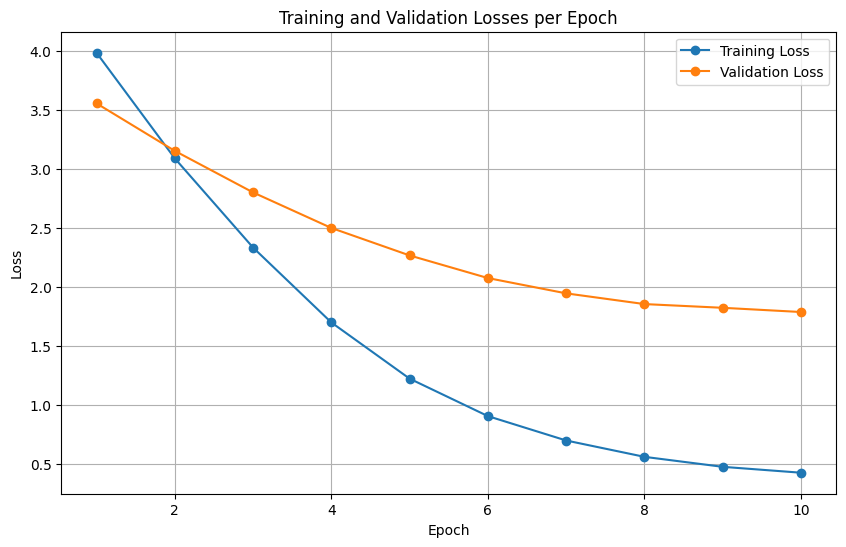

In [ ]:
plot_losses(train_loss_C, valid_loss_C)

## Generación de Poemas

In [ ]:
##Experimentar con diferentes prompt

prompt = "<BOS>" #libre

if tipo_tokenizer == "tiktoken":
  generated = torch.tensor(tokenizer.encode(prompt, allowed_special="all")).unsqueeze(0)

if tipo_tokenizer == "preentrenado":
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

generated = generated.to(device)

In [ ]:
model_sologpt.eval()

TEMPERATURA = 0.6

sample_outputs = model_sologpt.generate(
                                generated,
                                do_sample=True,
                                max_length=80,
                                top_k = 0,
                                num_return_sequences=100,
                                temperature=TEMPERATURA,
                                renormalize_logits = True
                                )

for i, sample_output in enumerate(sample_outputs):
    if tipo_tokenizer == "tiktoken":
      print("\n\nPoema Generado N° {}: \n\n {}\n\n".format(i, tokenizer.decode(sample_output.tolist())))
    if tipo_tokenizer == "preentrenado":
      print("\n\nPoema Generado N° {}: \n\n {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




Poema Generado N° 0: 

 cuando camino de vuelta,
por encinas y pinares,
todavía me persigue
el aire.

no cuesta atrapar el matorral.
viene más puro que el alma,
más recto que el alma,
y se va más que el alma,
y se va más que el alma.
cuando sueño la pradera,
tengo que desprenderla de mi




Poema Generado N° 1: 

 a la catedral solemne llegaron,
y abriendo la gran puerta herrada,
entraron como langostinos
los hijos de madre granada.

en la catedral eran tantas naves
como cámaras en las granadas,
y los monaguillos iban y venían
en olas y olas encontradas...as, espadas,
puertas, puertas, cerrojos,
todo era enigma,




Poema Generado N° 2: 

 el viento errabundo en la noche
mece los trigos.
oyendo a los vientos amantes,
mezo a mi niño.

el viento errabundo en la noche
mece los trigos.
oyendo a los vientos amantes,
mezo a mi niño....!!!!: v




Poema Generado N° 3: 

 -¿y qué te creías, mama?

-que era una niña con los ojos
de oro y de rojez.
de mirarte así, con esos ojitos
de peces que 

In [ ]:
generated_poems = []

for i, sample_output in enumerate(sample_outputs):
  if tipo_tokenizer == "tiktoken":
            generated_poems.append(tokenizer.decode(sample_output.tolist()))
  else:
            generated_poems.append(tokenizer.decode(sample_output, skip_special_tokens=True))

output_file_path = f'ModeloC_prompt_libre_T_{int(TEMPERATURA*100)}.txt'

with open(output_file_path, 'w', encoding='utf-8') as file:
    for poem in generated_poems:
        file.write(poem + '\n\n\n')

print(f"Generated outputs are saved to: {output_file_path}")

Generated outputs are saved to: ModeloC_prompt_libre_T_60.txt


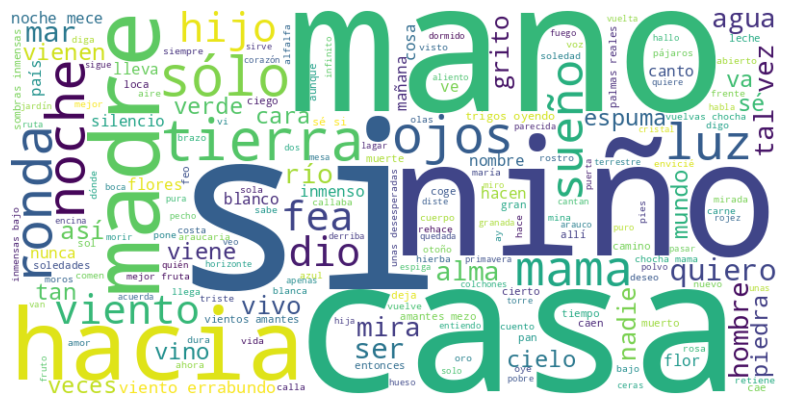

In [ ]:
archivo_path = f'ModeloC_prompt_libre_T_{int(TEMPERATURA*100)}.txt'

with open(archivo_path, 'r', encoding='utf-8') as file:
    contenido = file.read()

wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords = stopwords_espanol).generate(contenido)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
creatividad_altaT = evaluate_creativity(model_sologpt, tokenizer, poemas, temperatura = 1.0, num_context_inputs=100)
creatividad_bajaT = evaluate_creativity(model_sologpt, tokenizer, poemas, temperatura = 0.1, num_context_inputs=100)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 49


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 51


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 52


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 55


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 59


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 64


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 65


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 67


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 70


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 72


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 74


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 75


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 76


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 77


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 79


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 81


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 82


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 84


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 85


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 86


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 87


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 89


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 90


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 91


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 97


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 99


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 49


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 51


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 52


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 55


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 59


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 64


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 65


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 67


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 70


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 72


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 74


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 75


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 76


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 77


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 79


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 81


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 82


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 84


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 85


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 86


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 87


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 89


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 90


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 91


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 97


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto número: 99


In [ ]:
print(f"El puntaje de creatividad del modelo con alta T es: {np.round(creatividad_altaT, 2)}")
print(f"El puntaje de creatividad del modelo con baja T es: {np.round(creatividad_bajaT, 2)}")

El puntaje de creatividad del modelo con alta T es: 0.71
El puntaje de creatividad del modelo con baja T es: 0.41
